# Comparison: Year 2013, Old: 201905r New:201905r_wrap

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [8]:
year = '2013'
olddir = 'v201905r'
newdir = 'v201905r_wrap'

In [9]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=False, olddir=olddir, d201905=False, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
            f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(olddir)
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(newdir)
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [873]:
def profiles(tracers, file, olddir=olddir, d201905=False, dosum=False, zmax=39):
    zvalid = zmax
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    stdev_mean = np.empty(zvalid)
    for iz in range(zvalid):
        stdev_mean[iz] = mean_field[iz].flatten().std()
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
    stdev_new = np.empty(zvalid)
    for iz in range(zvalid):
        stdev_new[iz] = field[iz].flatten().std()
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    axs[0].set_title('Mean Profiles')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    axs[1].set_title('Differences in Profiles')
    
    rmsd = np.empty(zvalid)
    for iz in range(zvalid):
        rmsd[iz] = np.sqrt(((field[iz] - mean_field[iz])**2).mean(axis=0).mean(axis=0))
        
    axs[2].plot(stdev_mean, deptht[:zvalid], label="Old")
    axs[2].plot(stdev_new, deptht[:zvalid], label="New")
    axs[2].plot(rmsd, deptht[:zvalid], label="RMSD")
    axs[2].set_title("Standard Deviations and RMS Difference")
    
    for ax in axs:    
        ax.invert_yaxis()
        ax.legend(loc='best')
    
    ratio_ax = axs[2].twiny()
    ratio_ax.plot(rmsd/stdev_new, deptht[:zvalid], c='tab:red')
    
    print ((rmsd/stdev_new).max())
    
    
    ds.close()
    dm.close()

    ratio_ax.plot([0.1, 0.1], [deptht[0], deptht[zvalid]], 'k-')
    
    return fig

In [11]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, d201905=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][0])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

### Temperature ###

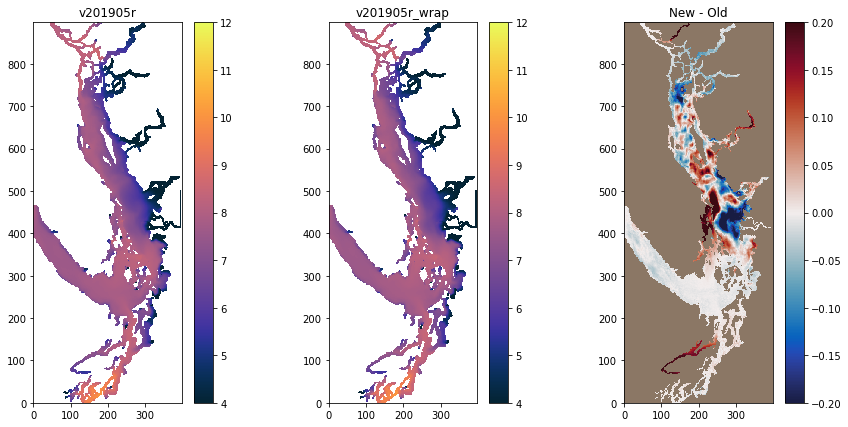

In [958]:
tracer = 'votemper'
file = 'grid'
month = '12'
cmap = cm.thermal
cdiff = cm.balance
vmax = 12
vmin = 4
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

9.190621672398683 9.123882184507483
0.975419594164008


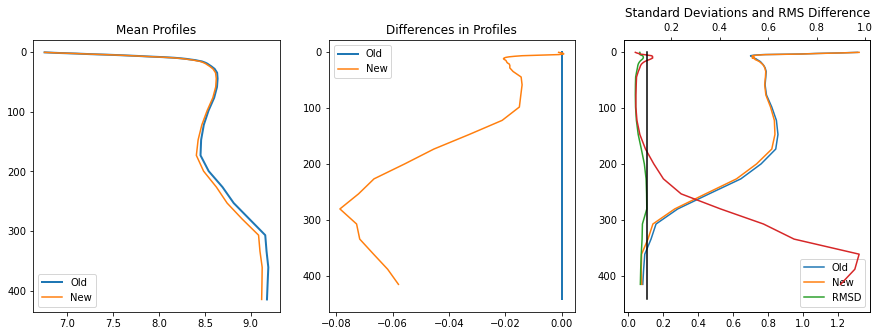

In [959]:
fig = profiles(tracer, file)

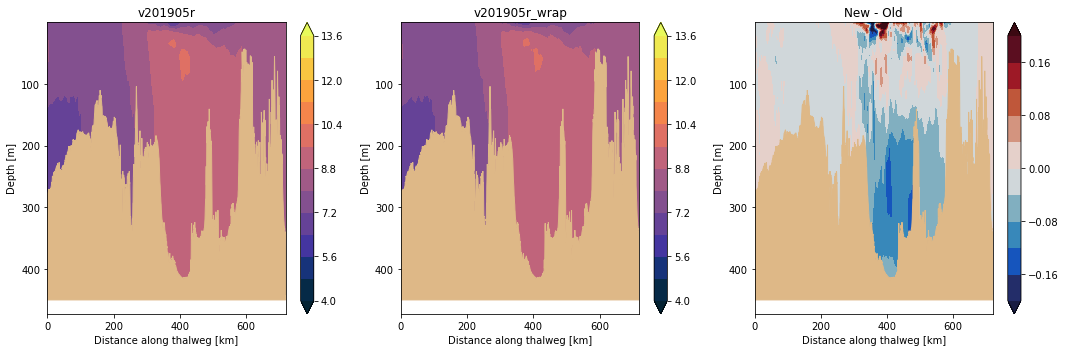

In [960]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: deep JdF 0.6o warmer, warm on surface in fjords, max on profile -0.15(deep) to 0.20, nonething spun up
* February: JdF 0.3o warm, SoG cool, max on profile -0.125(deep) to 0.05
* March: Puget surface 0.2o warm, SoG cool, max on profile -0.11(deep) to 0.0
* April: Puget surface patchy, max on profile -0.09(deep) to -0.01
* May: looking patchy, max on profile -0.08(deep) to -0.02
* June: max -0.055(deep) to 0
* July: max -0.055 -0.045(deep) to -0.005
* August: max -0.07 -0.045(deep) to -0.02
* September: max -0.08 -0.045(deep) to -0.03
* October: max -0.08 -0.045(deep) to -0.02
* November: max -0.08 -0.05(deep) to -0.02, good to 180m
* December: max -0.08 -0.55(deep) to 0

### Nitrate ###

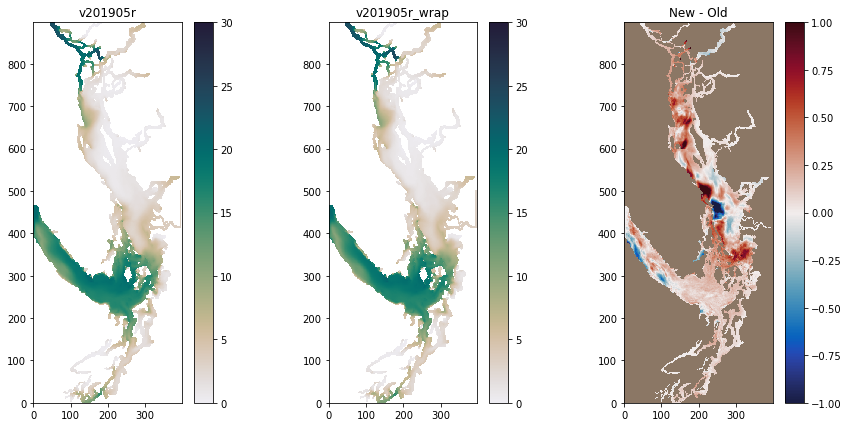

In [1044]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

29.089679579145013 29.414146055535053
1.2441349143022955


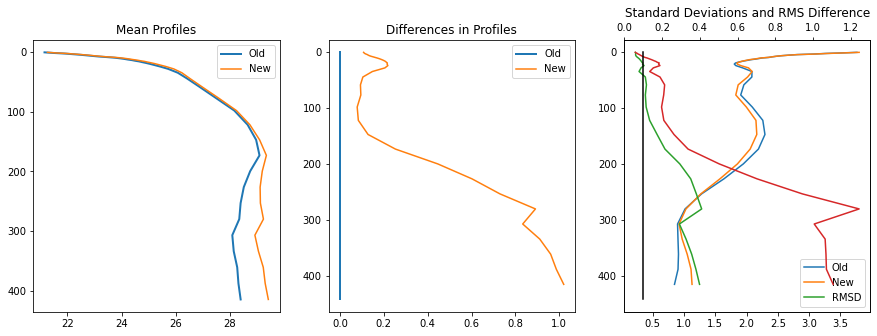

In [1053]:
fig = profiles(tracer, file)

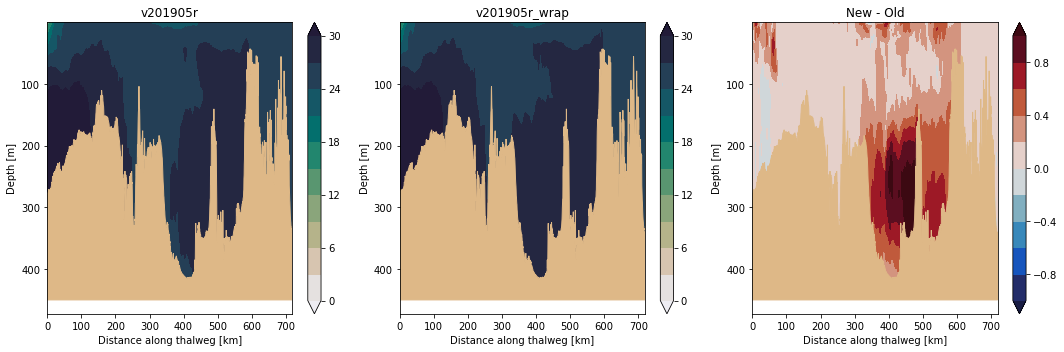

In [1054]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: surface mouth JdF 8uM higher, max on profile -0.25 to 0.9(deep) to 1.5, nonething spun
* February: surface JdF 2uM higher, deep SoG 2uM higher, max on profile -0.4 to 0.9(deep)
* March: surface SoG & JdF 2uM higher, deep north SoG 2uM higher, max on profile -0.1 to 0.9(deep)
* April: surface patchy upto SoG 2uM higher, deep SoG 2uM higher, max on profile 0.1 to 0.8(deep)
* May: surface patchy but higher, deep SoG 1.5uM higher, DWR? 2 higher, max on profile 0 to 0.8(deep)
* June: surface v similar, higher at 30 m and deep, max on profile 0 to 0.8(deep)
* July: surface v similar, higher at 30 m and deep, max on profile 0 to 0.7(deep)
* August: surface v similar, higher at 30 m (fading) and deep, max on profile 0 to 0.8(deep)
* September: max on profile 0 to 0.7(deep)
* October: max on profile 0.1 to 0.75(deep)
* November: max on profile 0.1 to 0.75(deep), good to 5 m
* December: max on profile 0.1 to 1.1(deep), good to 5 m

### Diatoms ###

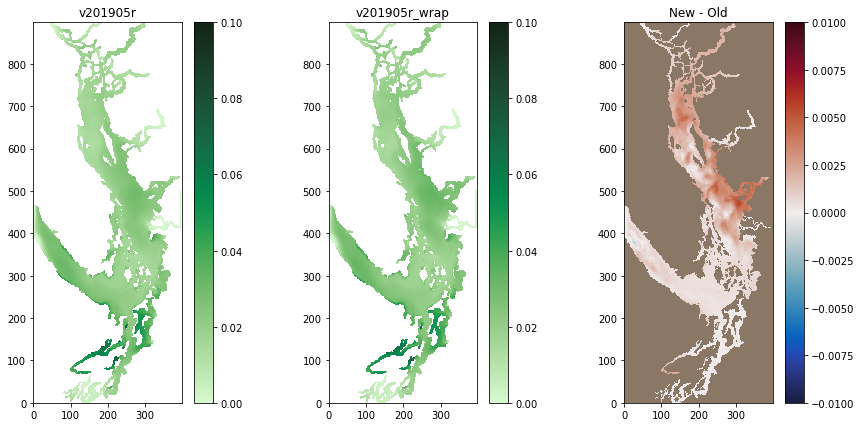

In [964]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.1
vmin = 0
dvmax = 0.01
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)


0.022266814242024664 0.023624128835447965
0.294296010761935


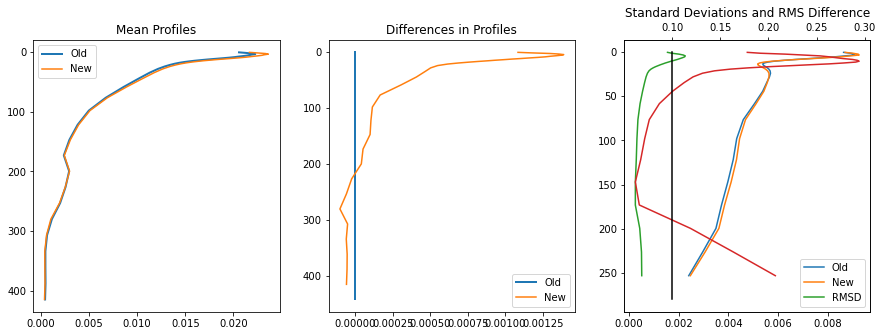

In [965]:
fig = profiles(tracer, file, zmax=33)

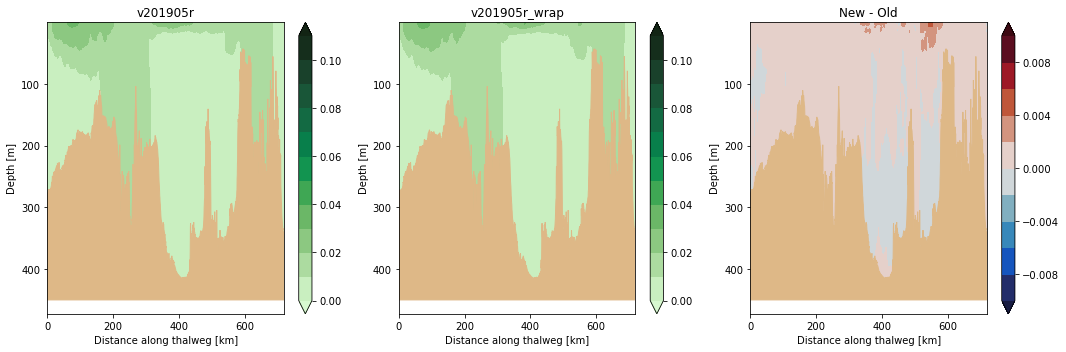

In [966]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: low on surface particularly in Hood, max on profile -0.008 (out of 0.012!)
* February: significantly low on surface particularly in Hood, max on profile -0.020 (out of 0.025!)
* March: significantly low on surface particularly in SoG, max on profile -0.20 (out of 0.45!)
* April: much closer, patchy surface SoG, max on profile -0.07 to 0.02 (out of 2)
* May: patchy, max on profile -0.004 to 0.008(out of 1.75)
* June: max on profile -0.035 to 0.0(out of 1.5)
* July: max on profile -0.015 to 0.0(out of 1.75)
* August: max on profile 0 to 0.0175(out of 1)
* September: max on profile 0 to 0.015(out of 0.25)
* October: max on profile -0.0002 to 0.0003(out of 0.06)
* November: max on profile 0 to 0.0012(out of 0.05)
* December: max on profile 0 to 0.00125(out of 0.025)

### Microzooplankton ###

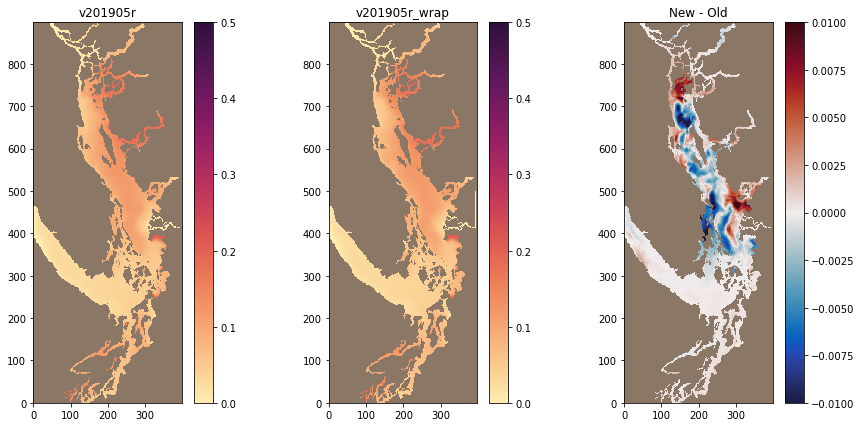

In [967]:
tracer = 'microzooplankton'
file = 'ptrc'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 0.5
vmin = 0
dvmax = 0.01
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.06445153658162912 0.0643570432016642
0.5322471327001361


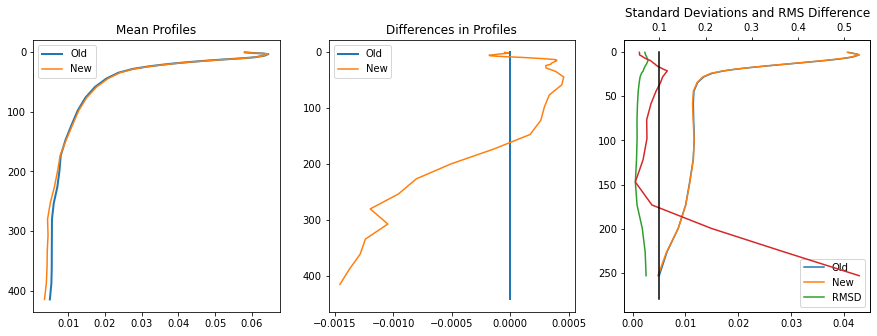

In [968]:
fig = profiles(tracer, file, zmax=33)

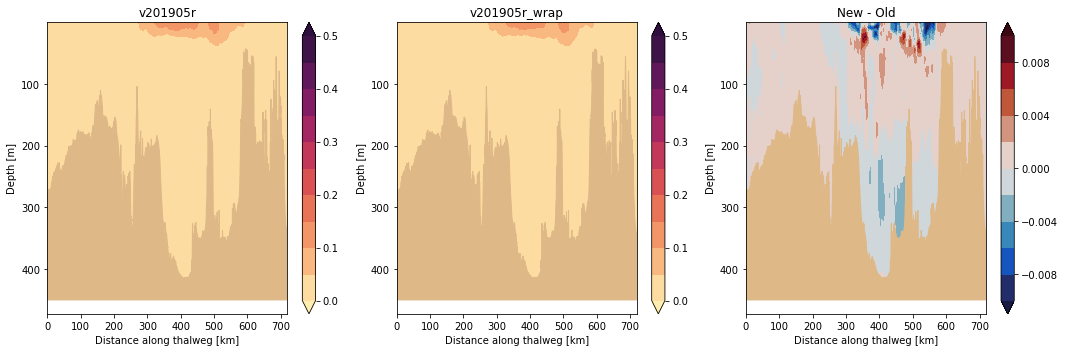

In [969]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: very similar, max on profile -0.010 to 0.002 (out of 0.07)
* February: very similar, max on profile -0.001 to 0.004 (out of 0.12)
* March: very similar, max on profile -0.008 to 0.001 (out of 0.175)
* April: very similar, max on profile -0.015 to 0.005 (out of 0.7)
* May: very similar, max on profile -0.025 to 0.001 (out of 0.5)
* June: max on profile -0.0075 to 0.005 (out of 0.5)
* July: max on profile -0.006 to 0.006 (out of 0.7)
* August: max on profile -0.008 to 0.006 (out of 0.4)
* September: max on profile -0.007 to 0.004 (out of 0.2)
* October: max on profile -0.004 to 0.002 (out of 0.14)
* November: max on profile -0.0017 to 0.0007 (out of 0.09)
* December: max on profile -0.0015 to 0.0005 (out of 0.06) mostly good to 180 m

### Salinity ###

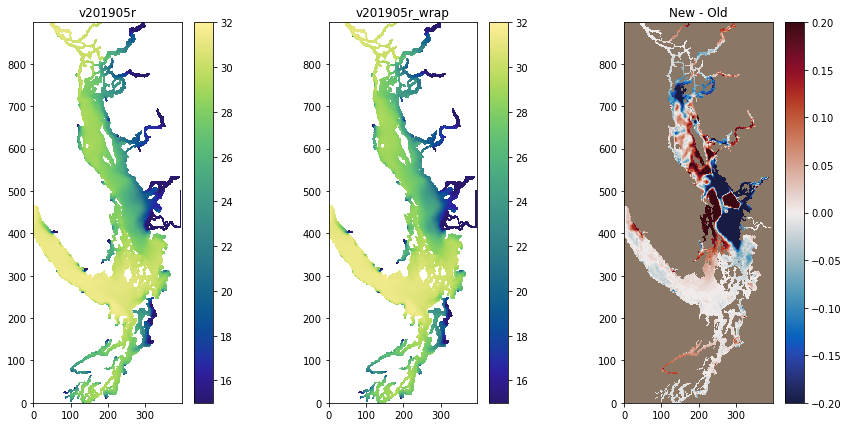

In [1039]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

31.908458318229144 31.924517027927557
0.38536430440846364


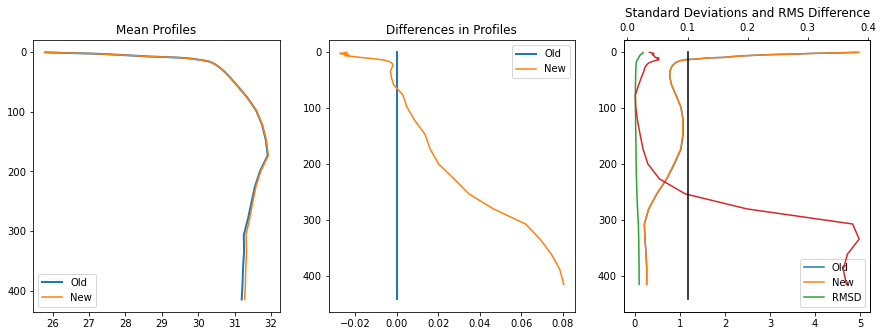

In [1040]:
fig = profiles(tracer, file)

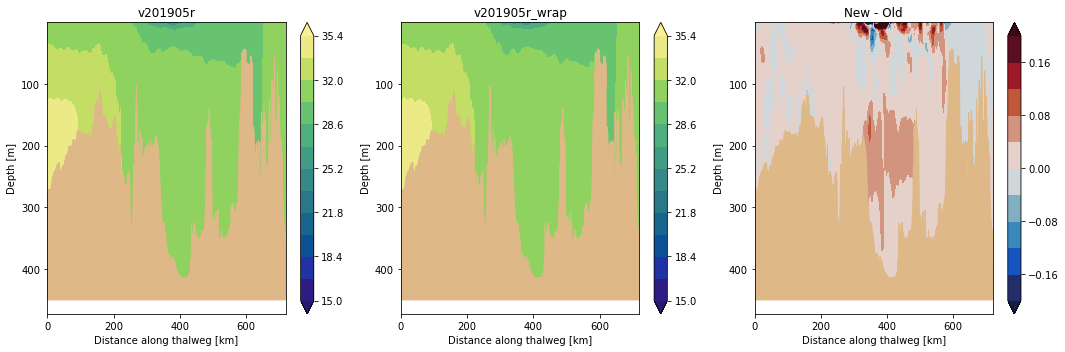

In [1041]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: SoG mixed on surface, fresh below surface-100m, max on profile -0.45 to 0.15(deep value), nonething spun
* February: surface small and patchy, max on profile -0.3 to 0.15(deep value)
* March: patchy on surface, fresh from surface to 100m, max on profile -0.22 to 0.15(deep value)
* April: patchy mostly fresh on surface, fresh around 50 m, max on profile -0.17 to 0.15(deep value)
* May: patchy, no clear cool band, max on profile -0.15 to 0.15(deep value)
* June: max on profile -0.12 to 0.15(deep value)
* July: max on profile -0.07 to 0.15(deep value)
* August: max on profile -0.05 to 0.14(deep value)
* September: max on profile -0.02 to 0.12(deep value)
* October: max on profile -0.01 to 0.11(deep value)
* November: max on profile -0.03 to 0.095(deep value), good above 250 m
* December: max on profile -0.02 to 0.08(deep value), good above 260 m

### Flagellates ###

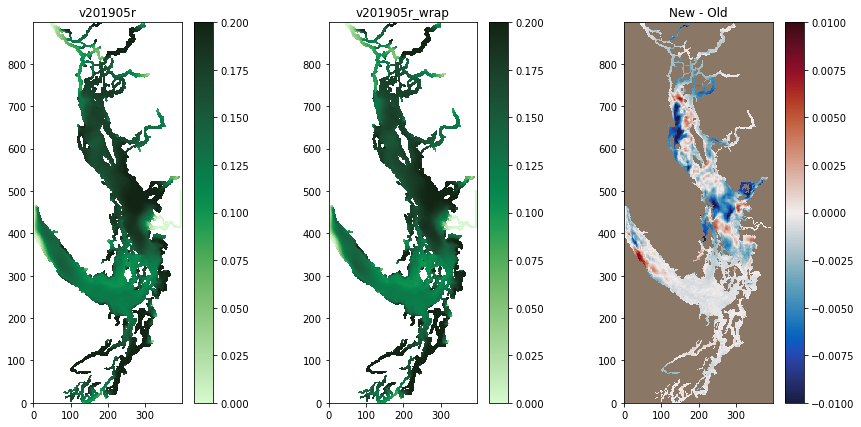

In [973]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.2
vmin = 0
dvmax = 0.01
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.1409081525200212 0.1395330187543676
0.24407028007843823


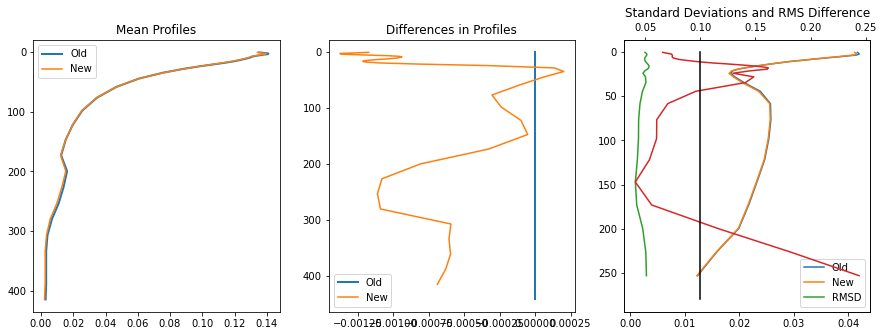

In [974]:
fig = profiles(tracer, file, zmax=33)

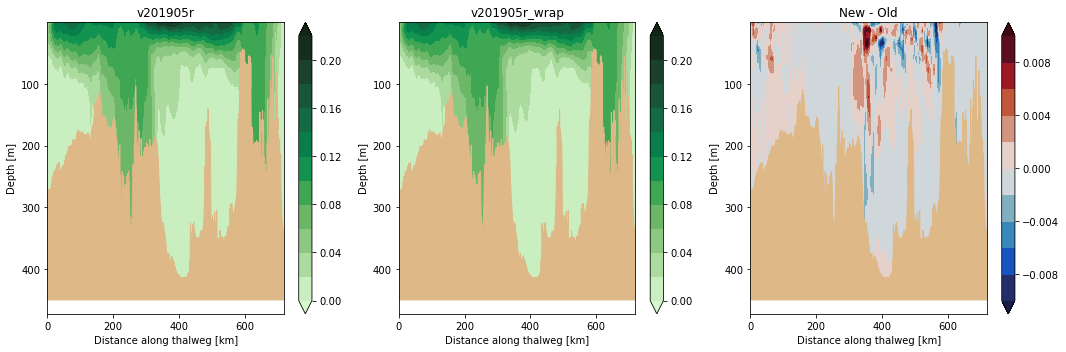

In [975]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: more flag especially near mouth JdF, max on profile -0.01 to 0.04 (out of 0.25)
* February: more flag surface, max on profile -0.002 to 0.02 (out of 0.28)
* March: very similar, max on profile -0.01 to 0.005 (out of 0.30)
* April: more flagellates, max on profile 0 to 0.035 (out of 0.25)
* May: patchy, max on profile -0.0005 to 0.0035 (out of 0.15)
* June: more flagellates, max on profile 0 to 0.04 (out of 0.7)
* July: regional, max on profile 0 to 0.025 (out of 0.9)
* August: regional, max on profile -0.020 to 0.0 (out of 0.7)
* September: more flagellates, max on profile 0 to 0.04 (out of 0.6)
* October: patchy, max on profile -0.001 to 0.0001 (out of 0.10)
* November: patchy, max on profile -0.001 to 0 (out of 0.10)
* December: patchy, max on profile -0.00125 to 0.00025 (out of 0.14) good to 10 m

### NH4 ###

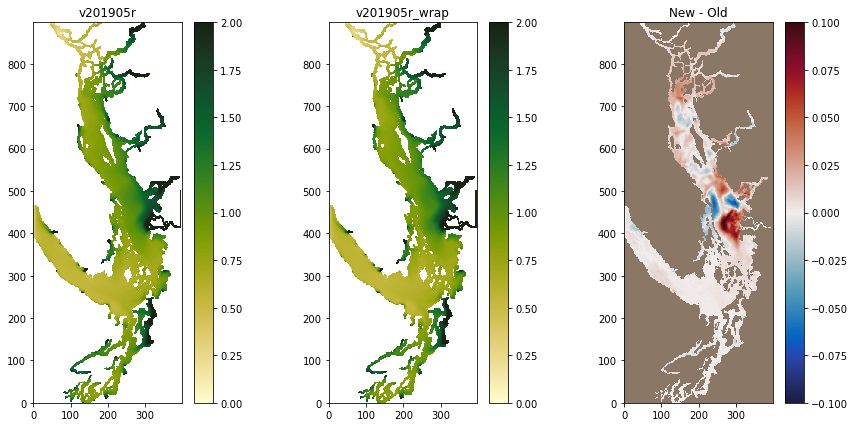

In [1025]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.1122901062603512 1.117329511039682
1.146903449087129


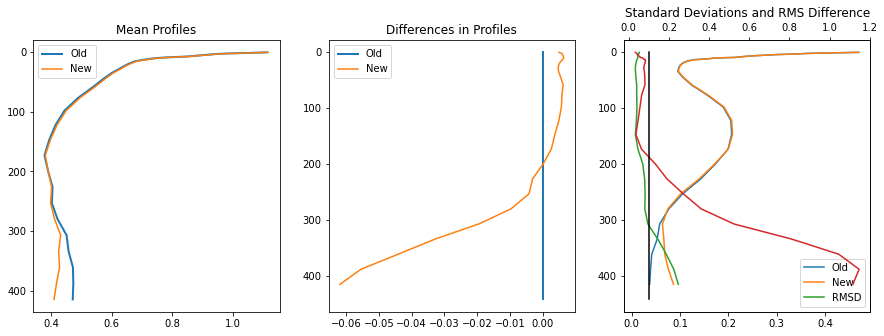

In [1026]:
fig = profiles(tracer, file)

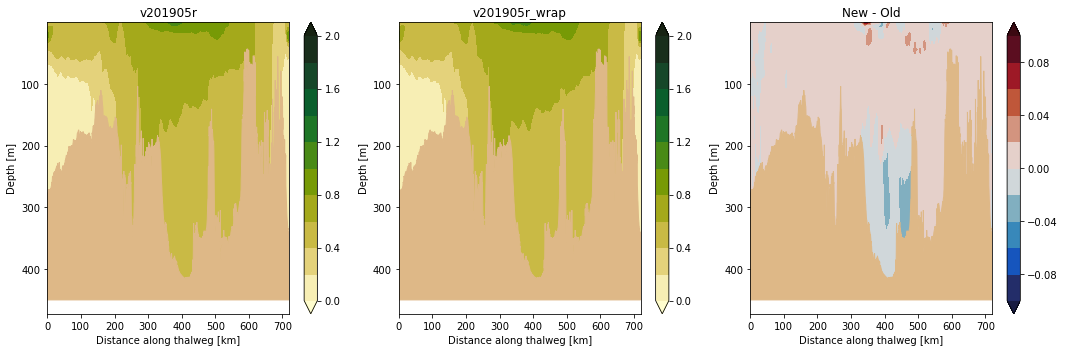

In [1027]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### SSH ###

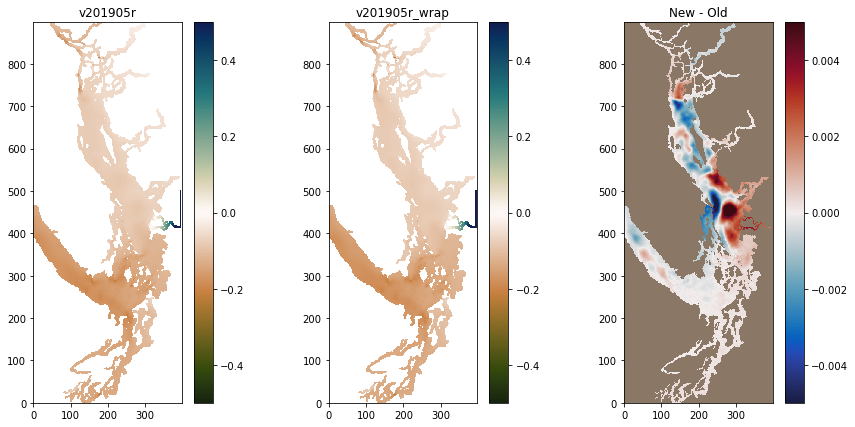

In [979]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.005
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True)

### Oxygen ###

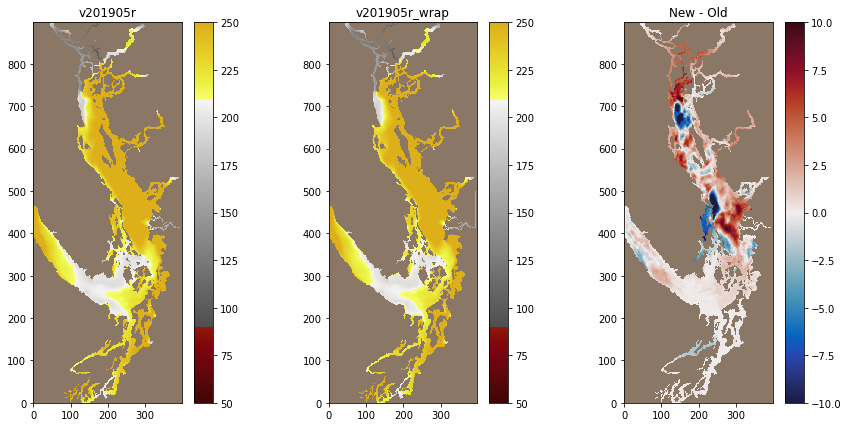

In [980]:
tracer = 'dissolved_oxygen'
file = 'carp'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 250
vmin = 50
dvmax = 10
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

230.4488897548686 231.0903560520856
0.9951998687121597


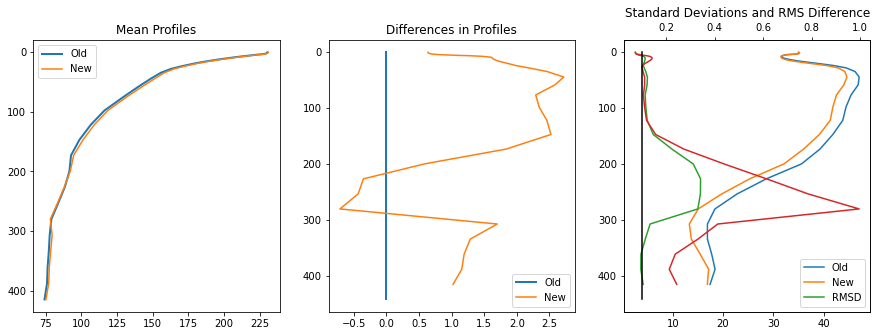

In [981]:
fig = profiles(tracer, file)

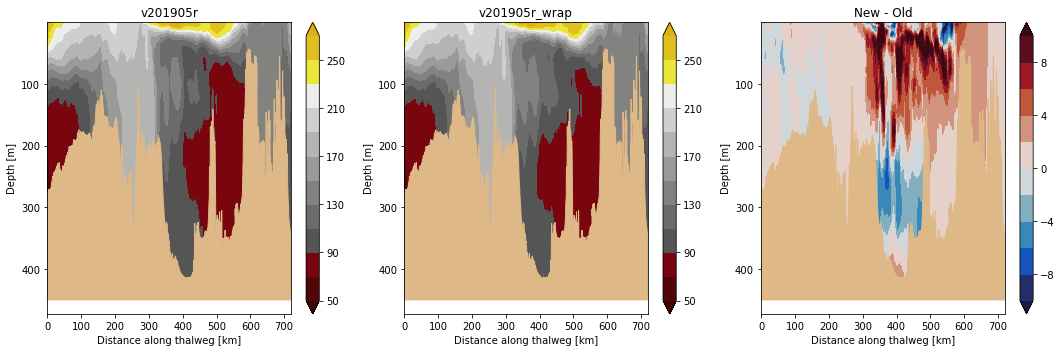

In [982]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: most different profile, much more oxygen surface to 100 m in SoG, max on profile -2 to 35 (out of 250)
* February: most different profile, getting closer, more oxygen surface to 100 m in SoG, max on profile -1 to 25 (out of 250)
* March: getting closer, more oxygen at 70 m in SoG, max on profile 0 to 17.5(deep) (out of 280)
* April: getting closer, more oxygen at 70 m in SoG, max on profile 1 to 17.5(deep) (out of 300)
* May: surface patchy, more oxygen at 70 m in SoG, max on profile 1.5 to 17.5(deep) (out of 280)
* June: surface similar, more oxygen at 70 m in north SoG, max on profile 2 to 17.5(deep) (out of 270): thalweg says less at depth????
* July: surface similar, more oxygen at 70 m in north SoG, max on profile 2 to 17(deep) (out of 260): thalweg says less at depth????
* August: surface similar, more oxygen at 70 m in north SoG, max on profile 2 to 17(deep) (out of 240): thalweg says less at depth????
* September: surface similar, more oxygen at 70 m in SoG, max on profile 2 to 14(deep) (out of 210): thalweg says less at depth????
* October: surface similar, more oxygen at 70 m in SoG, max on profile 1 to 9(deep) (out of 200): thalweg says less at depth????
* November: surface similar, more oxygen at 70 m in SoG, max on profile 1 to 7(deep) (out of 210)
* December: profile looks good, more at 80 m, less at 300 m, max on profile -0.5 to 1.7(deep) to 2.5, good to 5 m

### PON ###

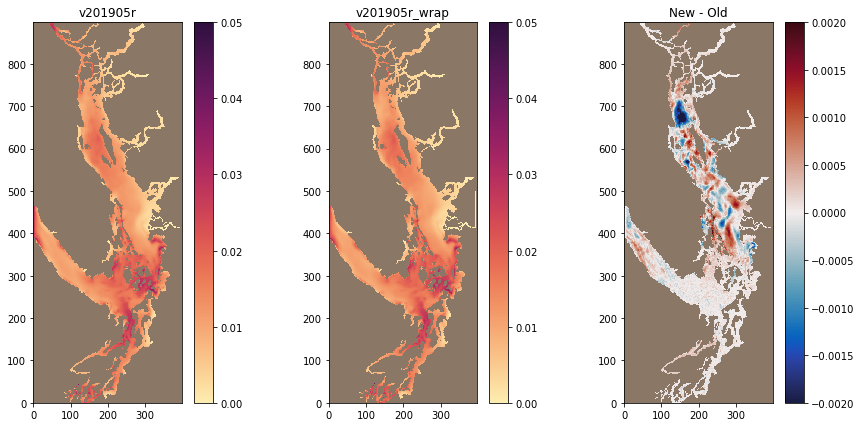

In [986]:
tracer = 'particulate_organic_nitrogen'
file = 'ptrc'
cmap = cm.matter
cdiff = cm.balance
vmax = 0.05
vmin = 0
dvmax = 0.002
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.029788732602035316 0.02997844922923322
0.21297835870924364


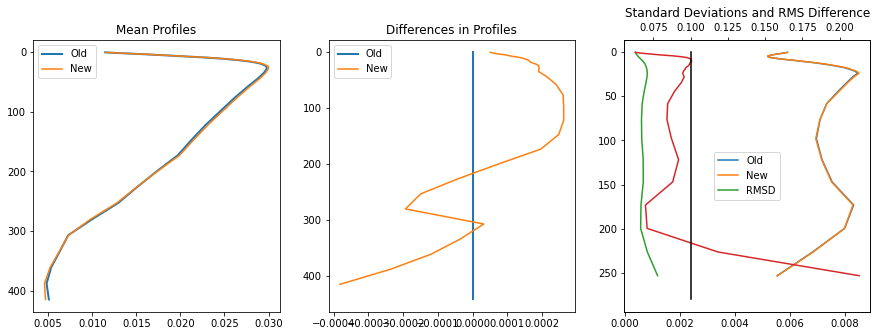

In [987]:
fig = profiles(tracer, file, zmax=33)

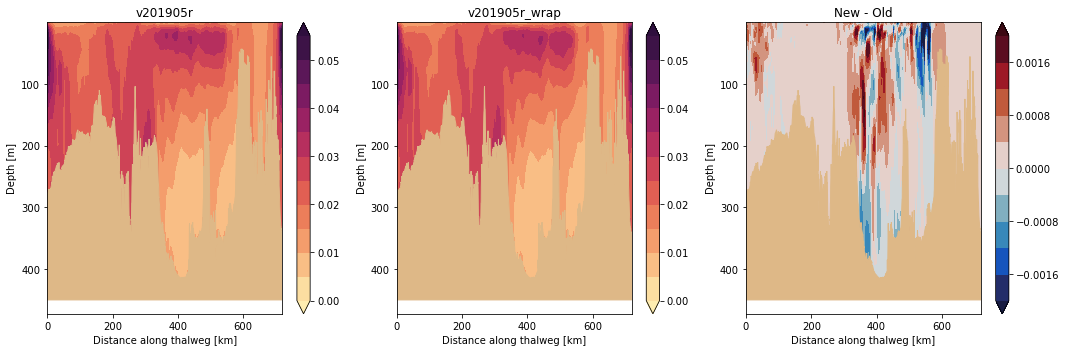

In [988]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Silicon ###

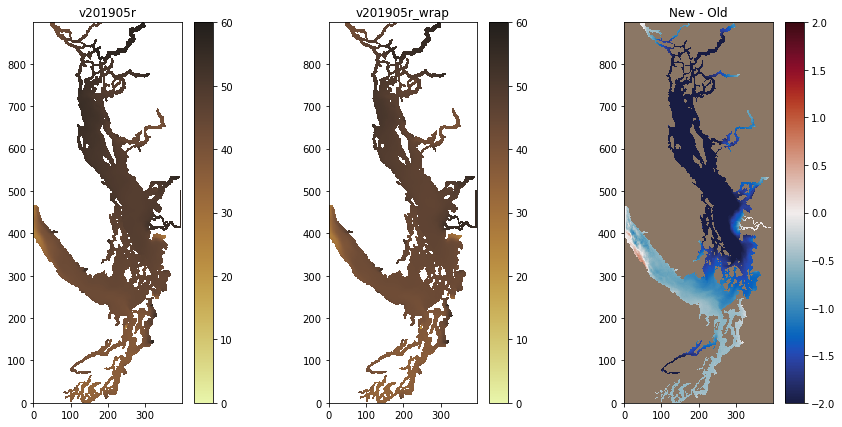

In [1033]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

64.42421425837699 71.17398085359119
0.9259090881978288


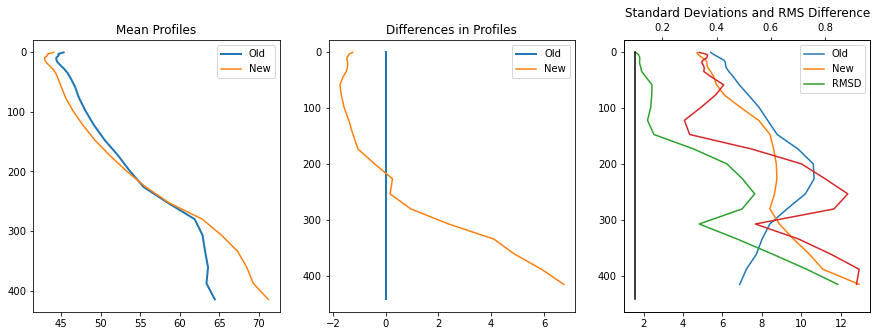

In [1034]:
fig = profiles(tracer, file)

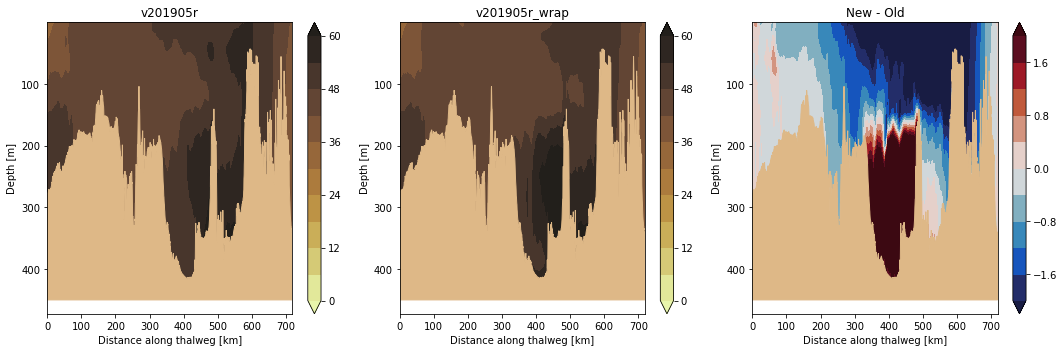

In [1035]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### DIC ###

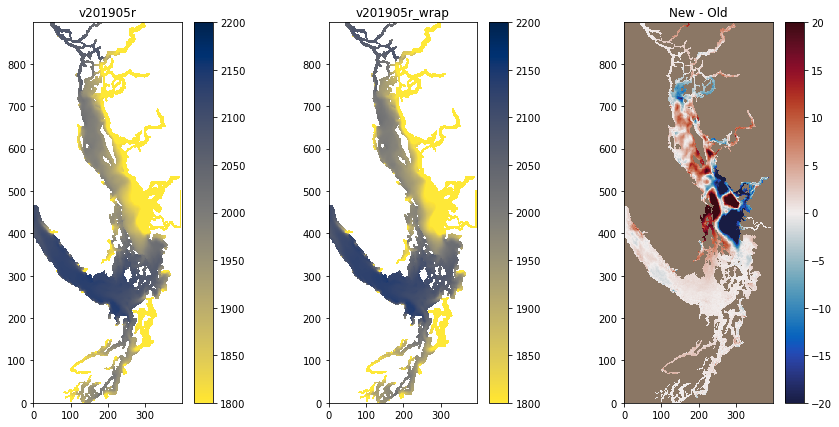

In [992]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2182.901189827886 2185.6511012509695
0.8699249884852203


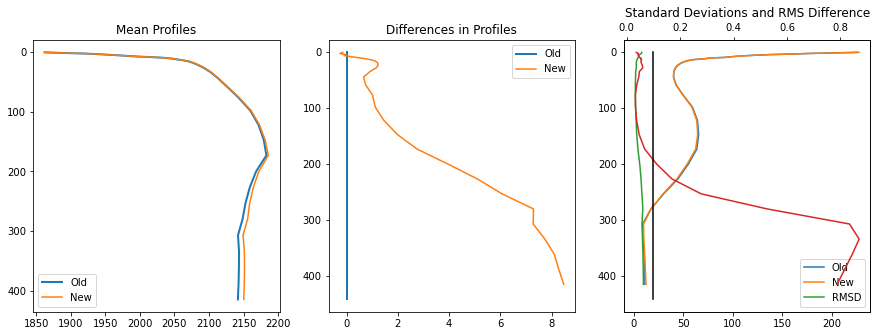

In [993]:
fig = profiles(tracer, file)

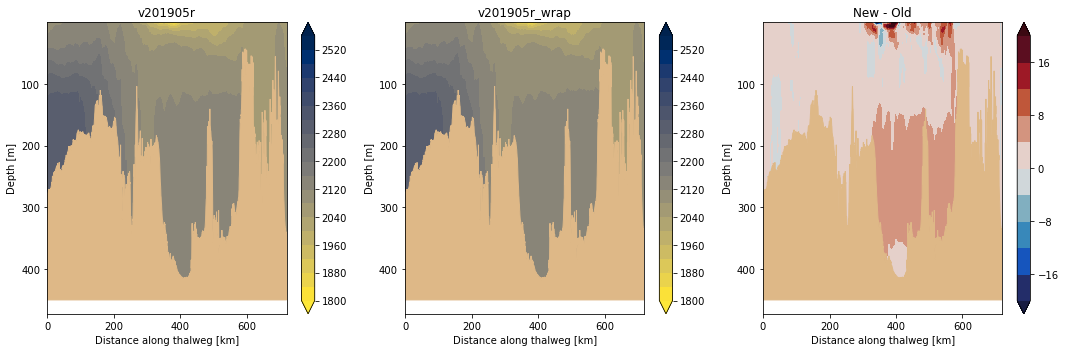

In [994]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Alkalinity ###

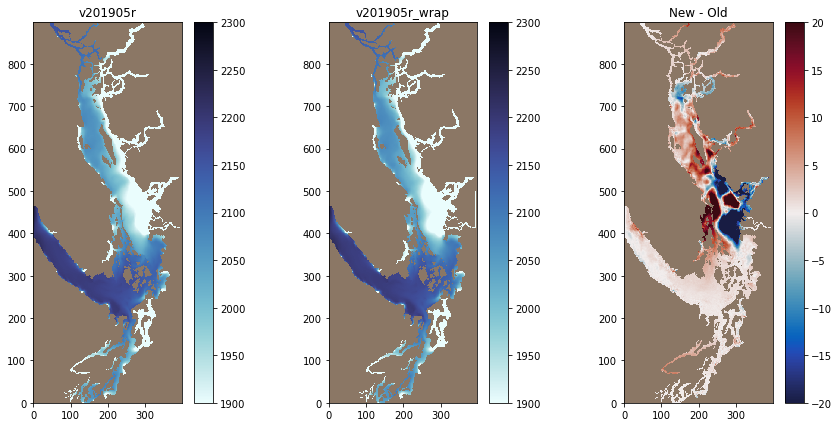

In [995]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2214.2051545102395 2217.4473059452484
0.7293478244497009


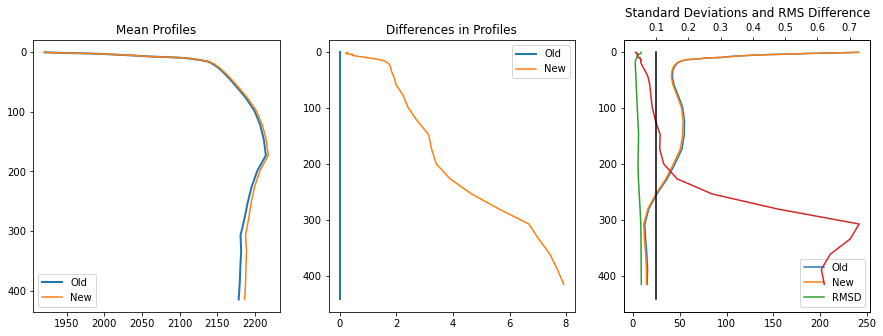

In [996]:
fig = profiles(tracer, file)

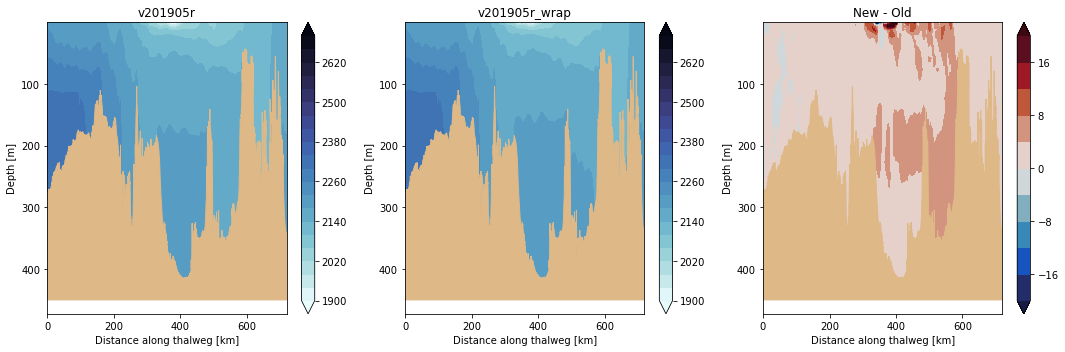

In [997]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Fraser Tracer ###

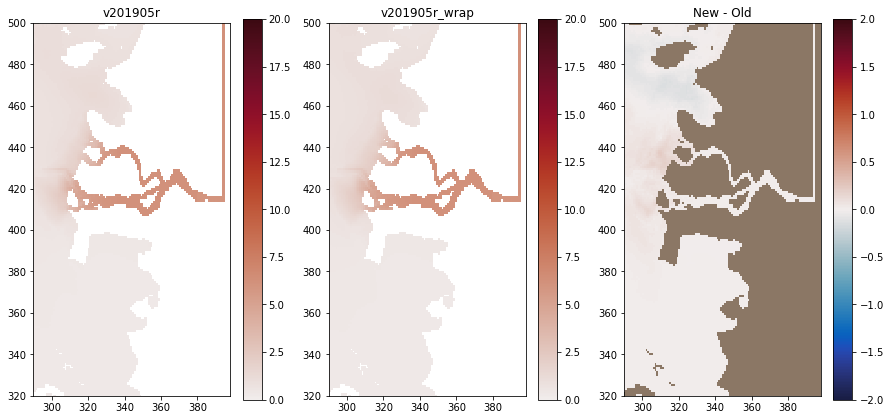

In [998]:
tracer = 'Fraser_tracer'
file = 'carp'
cmap = cm.amp
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, dl=3,
                    zoom=[320, 500, 290, 398])